In [1]:
import sympy as sp # sympy==1.4
import pandas as pd # pandas==0.25.1
import numpy as np # numpy==1.17.2

from scipy.sparse.linalg import expm_multiply # scipy==1.3.1 (different version might create offset)

from tqdm import tqdm # just for displaying the progress bar

# Define some classes for later use

In [2]:
# general functions

def Vector(name, n):
    """Construct a symbolic vector."""
    x = sp.IndexedBase(name, (n,))
    x = sp.Matrix([x[i] for i in range(n)])
    return x

def Matrix(name, n, m):
    """Construct a symbolic matrix."""
    x = sp.MatrixSymbol(name, n, m)
    x = sp.Matrix([[x[i, j] for j in range(m)] for i in range(n)])
    return x

def Generator(name, n):
    """Construct a symbolic generator matrix (rows adding up to zero)."""
    x = sp.MatrixSymbol(name, n, n)
    x = sp.Matrix([[x[i, j] for j in range(n)] for i in range(n)])
    for i in range(n):
        x[i, i] -= sum(x[i, j] for j in range(n))
    return x

def e(i, n):
    """Construct a basis vector."""
    return sp.Matrix([1 if i == j else 0 for j in range(n)])

def taylor(f, x, x0, order=1):
    
    """Taylor approximation of f in x around x0, of given order."""

    n = x.shape[0]
    if n == 1:
        t = sp.Symbol('t')
        return f.subs(x[0], t).series(t, x0[0], order + 1).subs(t, x[0]).removeO()
    else:
        hlist = ['__h' + str(i+1) for i in range(n)]
        command = ''
        command = "sp.symbols('" + '  '.join(hlist) + "')"
        hvar = eval(command)
        # taylor is utaylor for specificly defined function
        t = sp.Symbol('t')
        # substitution
        locf = f
        for i in range(n):
            locvar = x[i]
            locsubs = x0[i] + t * hvar[i]
            locf = locf.subs(locvar, locsubs)
        # calculate taylorseries
        g = 0
        for i in range(order + 1):
            g += locf.diff(t, i).subs(t, 0) * t**i / np.math.factorial(i)
        # resubstitute
        for i in range(n):
            g = g.subs(hlist[i], x[i] - x0[i])
        g = g.subs(t, 1)    
        return g

# Sequential process-specific stuff

def sequentialprocess(f, y, y0, z, k):
    
    """Decompose a function of y and z into relevant terms. Accounts for powers of z."""
    try:
        p = sp.Poly(f, *(y), *(z))
    except:
        p = sp.Poly(taylor(f, y, y0, k - 1), *(y), *(z))
    n = y.shape[0]
    m = z.shape[0]
    c = dict(zip(p.monoms(), p.coeffs())) # key value pairs
    taylor_k = k + 1
    for mon in list(c.keys()):
        # get some general info for this monom
        zcntr = np.count_nonzero(mon[-m:])
        zk = int(zcntr == 1) # order of z, after correcting
        yk = sum(mon[:n]) # order of y
        if yk + zk > k: # do a taylor approximation in y
            taylor_k = min(k, k - zk)
        if zcntr > 1: # if you have multiplication of different zs you get zero
            del c[mon]
        elif max(mon[-m:]) > 1: # higher powers of z are just z
            new_mon = (*mon[:n], *(int(bool(mon)) for i in mon[-m:]))
            c[new_mon] = c[new_mon] + c[mon] if new_mon in c else c[mon]
            del c[mon]
        elif zk == 0: # no exposures to z, so introduce them
            for i in range(m):
                new_mon = (*mon[:n], *(1 if i == j else 0 for j in range(m)))
                c[new_mon] = c[new_mon] + c[mon] if new_mon in c else c[mon]
            del c[mon]
  
    if taylor_k <= k:
        return sequentialprocess(taylor(f, y, y0, taylor_k), y, y0, z, k) # does it work?
    else:
        return c

class SequentialProcess():
    
    def __init__(self, k, y, y0, z, generator):
        self.k = k
        self.y = y
        self.z = z
        self.y0 = y0
        self.generator = generator
        self.f = {a.func for a in generator.atoms(sp.Function) if hasattr(a.func, 'name')}.pop()
        # create the monomial basis
        monoms_y = [y for y in sp.variations(range(k, -1, -1), self.n, True) if sum(y) <= k]
        monoms_z = [tuple((1 if i == j else 0) for i in range(self.m)) for j in range(self.m)]
        self.monoms = sorted([(*i, *j) for i in monoms_y for j in monoms_z if sum(i) + sum(j) <= k], key=sum)
        # fill the matrices
        self._B = self._derive_B()
        self._A = self._derive_A()
        
    @property
    def n(self):
        return self.y.shape[0]
    
    @property
    def m(self):
        return self.z.shape[0]
    
    def eval_gen(self, b):
        y = self.y
        z = self.z
        f = self.f
        m = self.m
        # substitute the function f(y, z)
        g = self.generator.subs(f(y, z), b)
        # substitute the functions f(y, e_j)
        g = g.subs({f(y, e(i, m)): b.subs({z[j]: int(j == i) for j in range(m)}) for i in range(m)})
        return g.doit() # execute evaluation of the operators
    
    def _derive_B(self):
        x = sp.Matrix([self.y, self.z])
        return pd.Series({mon: sp.prod(x[i]**mon[i] for i in range(x.shape[0])) for mon in self.monoms})
    
    def B(self, y=None, z=None):
        B = sp.Matrix(self._B)
        if y is not None:
            B = B.subs({self.y[i]: y[i] for i in range(self.n)})
        if z is not None:
            B = B.subs({self.z[i]: z[i] for i in range(self.m)})
        return B
          
    def _derive_A(self):
        m = self.m
        B = self._B
        A = pd.DataFrame(0, B.keys(), B.keys())
        for i, b in tqdm(B.items()):
            c = sequentialprocess(self.eval_gen(b), self.y, self.y0, self.z, self.k)
            A.loc[i, c.keys()] = c.values()
        return A.T
    
    def A(self, y0=None):
        A = sp.Matrix(self._A)
        if y0 is not None:
            A = A.subs({self.y0[i]: y0[i] for i in range(self.n)})
        return A

# CIR bond price example

In this example notebook we will consider two applications, first a Cox-Ingersoll-Ross zero-coupon bond price. The process is

$$
dY_t = K (\mu - Y_t)dt + \sigma\sqrt{Y_t} dW_t.
$$

We use a killing rate of $Y_t$ such that the bond price is the zeroth moment,
$$
P(t,y) = \mathbb{E}_y\left[Y_t^0\right] = \mathbb{E}_y\left[\exp{\left\{-\int_0^t{\tilde{Y}_sds}\right\}}\right],
$$
where $\tilde{Y}_t$ is the process without killing.

The (killed) process $Y_t$ has generator,
$$
\mathcal{A}f(y)=K(\mu - y)\frac{\partial}{\partial y}f(y)+\tfrac12\sigma^2y\frac{\partial^2}{\partial y^2}f(y)-yf(y).
$$

Because we later want to consider processes with regime switching components, we add state $z$ that describes the regime as a basis vector. In this particular case we can assume there is only one state, with value $z=1$ to get the exact same generator,
$$
\mathcal{A}f(y,z)=K(\mu - y)\frac{\partial}{\partial y}f(y,z)+\tfrac12\sigma^2y\frac{\partial^2}{\partial y^2}f(y,z)-yzf(y,1).
$$

In [3]:
# dimensions
n = 1 # number of driving processes X
m = 1 # number of regimes Z

# process values
y = Vector('y', n)
y0 = Vector('a', n)
z = Vector('z', m)

# drift parameters
K = Matrix('K', n, n)
mu = Vector('mu', n)

# diffusion parameters
sigma2 = Vector('sigma^2', n)

# generators of Markov chain
Q = [Generator(f'Q^{{({i})}}', m) for i in range(n)]

In [4]:
f = sp.Function('f')

# create the infinitesimal generator of the stochastic process
G = K[0,0] * (mu[0] - y[0]) * sp.Derivative(f(y, z), y[0]) \
    + sigma2[0] * y[0] / 2 * sp.Derivative(f(y, z), y[0], y[0]) \
    - y[0] * z[0] * f(y, e(0, m))

G

(mu[0] - y[0])*K[0, 0]*Derivative(f(Matrix([[y[0]]]), Matrix([[z[0]]])), y[0]) + sigma^2[0]*y[0]*Derivative(f(Matrix([[y[0]]]), Matrix([[z[0]]])), (y[0], 2))/2 - y[0]*z[0]*f(Matrix([[y[0]]]), Matrix([[1]]))

We can use this generator to derive the matrix $A_k$ for some order. Note that the code works with the transposed value.

In [5]:
k = 15
pp = SequentialProcess(k, y, y0, z, G)

15it [00:01, 10.57it/s]


In [6]:
pp.B().T

Matrix([[z[0], y[0]*z[0], y[0]**2*z[0], y[0]**3*z[0], y[0]**4*z[0], y[0]**5*z[0], y[0]**6*z[0], y[0]**7*z[0], y[0]**8*z[0], y[0]**9*z[0], y[0]**10*z[0], y[0]**11*z[0], y[0]**12*z[0], y[0]**13*z[0], y[0]**14*z[0]]])

In [7]:
pp.A()

Matrix([
[ 0, mu[0]*K[0, 0],                            0,                              0,                              0,                               0,                               0,                               0,                               0,                               0,                                0,                                0,                                0,                                0,                                      -a[0]**15],
[-1,      -K[0, 0], 2*mu[0]*K[0, 0] + sigma^2[0],                              0,                              0,                               0,                               0,                               0,                               0,                               0,                                0,                                0,                                0,                                0,                                    15*a[0]**14],
[ 0,            -1,                   -2*K[0, 0], 3*mu[0]*K[0, 

By choosing specific values of of the parameters, we can compute the bond yields as,
$$
R(t)=-\frac{1}{t}\ln{P(t)},\qquad P(t)=b_k(y)^\top e^{tA_k}e_0.
$$
We do this for a grid of times to get the yield curve.

In [8]:
# the term structure over which we want to calculate prices
T = 30
tau = np.linspace(0, T, 121)[1:]

In [9]:
_K = 0.1
_sigma2 = 0.01
_mu = 0.03
_y = 0.05

A = np.array(pp.A().subs({
    K[0,0]: _K,
    sigma2[0]: _sigma2,
    mu[0]: _mu,
    y0[0]: _mu # choose around mean
}), dtype='float64')

B = np.array(pp.B().subs({y[0]: _y, z[0]: 1}), dtype='float')

<AxesSubplot:>

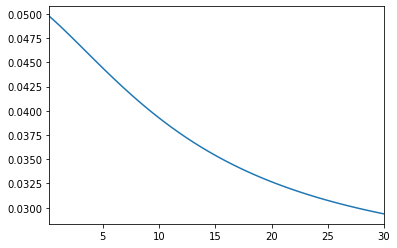

In [10]:
P = (B.T @ expm_multiply(A, np.eye(A.shape[1], 1), start=tau[0], stop=tau[-1], num=len(tau)).T)[0,0]
R = -1 / tau * np.log(P)
pd.Series(R, tau).plot()

We can compute this curve analytically to see how well the approximation works.

<AxesSubplot:>

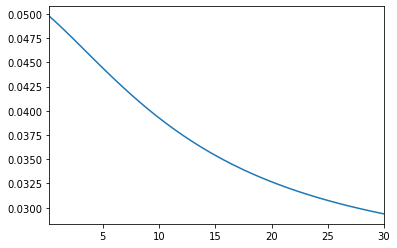

In [11]:
def CIR(tau, x0, a, b, sigma):
    h = (a**2 + 2 * sigma**2)**0.5
    A = ((2 * h * np.exp((a + h) * tau / 2)) / (2 * h + (a + h) * (np.exp(tau * h) - 1)))**(2 * a * b / sigma**2)
    B = 2 * (np.exp(tau * h) - 1) / (2 * h + (a + h) * (np.exp(tau * h) - 1))
    return A * np.exp(-B * x0)

P_cir = CIR(tau, _y, _K, _mu, _sigma2**0.5)
R_cir = -1 / tau * np.log(P_cir)

pd.Series(R_cir, tau).plot()

Comparing the two reveals an accurate yield, which can be made more accurate by increasing $k$.

<AxesSubplot:>

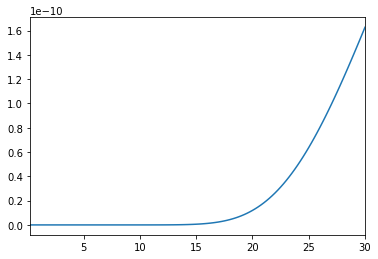

In [12]:
pd.Series(abs(R_cir - R), tau).plot()

# Rating migration model

Second, we consider the rating transition model outlined in the paper. To ensure we have an anlytical solution to benchmark against, we consider two independent CIR processes stacked in $X$, and a regime-switching process $Z$ that moves between three basis vectors in accordance with the generator,

$$
Q(y)=y_1Q_1+y_2Q_2.
$$

$Q_1$ and $Q_2$ are assumed to commute, and the structure of the process ensures that $Q(y)$ is a valid generator across the state space of the process, $\mathbb{R}^2$.

Based on derivations in the paper, we get the following generator, with $K$ diagonal,

$$
\mathcal{A}f(y,z)=\sum_{i=1}^n{\left(e_i^\top K(\mu-y)\frac{\partial}{\partial y_i}f(y,z)+\tfrac12\sigma_i^2y_i\frac{\partial^2}{\partial y_i^2}f(y,z)+y_iz^\top Q_i\begin{bmatrix}f(y,e_1)\\\vdots\\f(y,e_m)\end{bmatrix}\right)}
$$

In [13]:
# dimensions
n = 2 # number of driving processes X
m = 3 # number of regimes Z

# process values
y = Vector('y', n)
y0 = Vector('a', n)
z = Vector('z', m)

# drift parameters
K = Matrix('K', n, n)
mu = Vector('mu', n)

# diffusion parameters
sigma2 = Vector('sigma^2', n)

# generators of Markov chain
Q = [Generator(f'Q^{{({i})}}', m) for i in range(n)]

In [14]:
# the generator matrices only require off-diagonal input
Q[0]

Matrix([
[-Q^{(0)}[0, 1] - Q^{(0)}[0, 2],                  Q^{(0)}[0, 1],                  Q^{(0)}[0, 2]],
[                 Q^{(0)}[1, 0], -Q^{(0)}[1, 0] - Q^{(0)}[1, 2],                  Q^{(0)}[1, 2]],
[                 Q^{(0)}[2, 0],                  Q^{(0)}[2, 1], -Q^{(0)}[2, 0] - Q^{(0)}[2, 1]]])

In [15]:
drift = K * (mu - y)
diffs = sp.diag(*[sp.sqrt(sigma2[i] * y[i]) for i in range(n)])

G = sum(drift[i] * sp.Derivative(f(y, z), y[i]) for i in range(n)) \
    + sum((diffs * diffs.T)[i,j] / 2 * sp.Derivative(f(y, z), y[i], y[j]) for i in range(n) for j in range(n)) \
    + sum(y[i] * (z.T * Q[i][:,j] * f(y, e(j, m)))[0] for i in range(n) for j in range(m))

G

((mu[0] - y[0])*K[0, 0] + (mu[1] - y[1])*K[0, 1])*Derivative(f(Matrix([
[y[0]],
[y[1]]]), Matrix([
[z[0]],
[z[1]],
[z[2]]])), y[0]) + ((mu[0] - y[0])*K[1, 0] + (mu[1] - y[1])*K[1, 1])*Derivative(f(Matrix([
[y[0]],
[y[1]]]), Matrix([
[z[0]],
[z[1]],
[z[2]]])), y[1]) + ((-Q^{(0)}[0, 1] - Q^{(0)}[0, 2])*z[0] + z[1]*Q^{(0)}[1, 0] + z[2]*Q^{(0)}[2, 0])*y[0]*f(Matrix([
[y[0]],
[y[1]]]), Matrix([
[1],
[0],
[0]])) + ((-Q^{(0)}[1, 0] - Q^{(0)}[1, 2])*z[1] + z[0]*Q^{(0)}[0, 1] + z[2]*Q^{(0)}[2, 1])*y[0]*f(Matrix([
[y[0]],
[y[1]]]), Matrix([
[0],
[1],
[0]])) + ((-Q^{(0)}[2, 0] - Q^{(0)}[2, 1])*z[2] + z[0]*Q^{(0)}[0, 2] + z[1]*Q^{(0)}[1, 2])*y[0]*f(Matrix([
[y[0]],
[y[1]]]), Matrix([
[0],
[0],
[1]])) + ((-Q^{(1)}[0, 1] - Q^{(1)}[0, 2])*z[0] + z[1]*Q^{(1)}[1, 0] + z[2]*Q^{(1)}[2, 0])*y[1]*f(Matrix([
[y[0]],
[y[1]]]), Matrix([
[1],
[0],
[0]])) + ((-Q^{(1)}[1, 0] - Q^{(1)}[1, 2])*z[1] + z[0]*Q^{(1)}[0, 1] + z[2]*Q^{(1)}[2, 1])*y[1]*f(Matrix([
[y[0]],
[y[1]]]), Matrix([
[0],
[1],
[0]])) + ((-Q^{(1)}[2

In [16]:
# this is slow due to symbolic math. In actual implementation this can be made very fast.
k = 7
pp = SequentialProcess(k, y, y0, z, G)

0it [00:00, ?it/s]/usr/local/Miniconda3-py37_4.8.2-Linux-x86_64/envs/jupyter-pyfmg/lib/python3.6/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
84it [00:35,  2.37it/s]


In [17]:
pp.B().T

Matrix([[z[0], z[1], z[2], y[0]*z[0], y[0]*z[1], y[0]*z[2], y[1]*z[0], y[1]*z[1], y[1]*z[2], y[0]**2*z[0], y[0]**2*z[1], y[0]**2*z[2], y[0]*y[1]*z[0], y[0]*y[1]*z[1], y[0]*y[1]*z[2], y[1]**2*z[0], y[1]**2*z[1], y[1]**2*z[2], y[0]**3*z[0], y[0]**3*z[1], y[0]**3*z[2], y[0]**2*y[1]*z[0], y[0]**2*y[1]*z[1], y[0]**2*y[1]*z[2], y[0]*y[1]**2*z[0], y[0]*y[1]**2*z[1], y[0]*y[1]**2*z[2], y[1]**3*z[0], y[1]**3*z[1], y[1]**3*z[2], y[0]**4*z[0], y[0]**4*z[1], y[0]**4*z[2], y[0]**3*y[1]*z[0], y[0]**3*y[1]*z[1], y[0]**3*y[1]*z[2], y[0]**2*y[1]**2*z[0], y[0]**2*y[1]**2*z[1], y[0]**2*y[1]**2*z[2], y[0]*y[1]**3*z[0], y[0]*y[1]**3*z[1], y[0]*y[1]**3*z[2], y[1]**4*z[0], y[1]**4*z[1], y[1]**4*z[2], y[0]**5*z[0], y[0]**5*z[1], y[0]**5*z[2], y[0]**4*y[1]*z[0], y[0]**4*y[1]*z[1], y[0]**4*y[1]*z[2], y[0]**3*y[1]**2*z[0], y[0]**3*y[1]**2*z[1], y[0]**3*y[1]**2*z[2], y[0]**2*y[1]**3*z[0], y[0]**2*y[1]**3*z[1], y[0]**2*y[1]**3*z[2], y[0]*y[1]**4*z[0], y[0]*y[1]**4*z[1], y[0]*y[1]**4*z[2], y[1]**5*z[0], y[1]**5*z[1

By choosing specific values of the parameters, we can compute the rating migration probabilities at any horizon as

$$
P(t,y)=\left(b_{k/m}(y)^\top\otimes I_m\right)e^{tA_k}(I,O)^\top.
$$

Note that $b_k$ is the basis of $y$ only, as outlined in the paper.

In [18]:
_K = np.array([[0.1, 0.0], [0.0, 0.1]])
_sigma2 = np.array([0.01, 0.01])
_mu = np.array([1.0, 1.0])
_y = np.array([1.5, 0.8])
_Q1 = np.array([[-0.11, 0.1, 0.01], [0.05, -0.15, 0.1], [0.0, 0.0, 0.0]])
_Q2 = np.array([[-0.01, 0.0, 0.01], [0.00, -0.01, 0.01], [0.0, 0.0, 0.0]])

A = np.array(pp.A().subs({
    **{K[i,j]: _K[i,j] for i in range(n) for j in range(n)},
    **{sigma2[i]: _sigma2[i] for i in range(n)},
    **{mu[i]: _mu[i] for i in range(n)},
    **{y0[i]: _mu[i] for i in range(n)}, # choose around mean
    # first migration matrix
    **{Q[0][i,j]: _Q1[i,j] for i in range(m) for j in range(m) if i != j},
    # second migration matrix
    **{Q[1][i,j]: _Q2[i,j] for i in range(m) for j in range(m) if i != j},
}), dtype='float64')

I = np.identity(m)
B = np.hstack([np.array(pp.B().subs({
    **{y[i]: _y[i] for i in range(n)},
    **{z[i]: I[i,j] for i in range(m)}
}), dtype='float') for j in range(m)])

In [19]:
# required once per parameter setting of the process
P = expm_multiply(A, np.eye(A.shape[0], m), start=tau[0], stop=tau[-1], num=len(tau))
# B should contain all required starting values of the process
P = (B.T @ P.T).T

In [20]:
P[12] # migration from t=0 to t=3

array([[0.61477076, 0.25124462, 0.13398462],
       [0.12562231, 0.51427291, 0.36010478],
       [0.        , 0.        , 1.        ]])

Due to the specific properties of the process ($Q_1$ and $Q_2$ commute, $Y_1$ and $Y_2$ are independent CIR processes), we can derive an analytical pricing formula. This formula is derived in the paper. We show the result here for verification. The accuracy can be improved by increasing the order.

In [21]:
w, v = np.linalg.eig(_Q1)
P_cir1 = np.stack([CIR(tau, -wi * _y[0], _K[0,0], -wi * _mu[0], (-wi * _sigma2[0])**0.5) for wi in w[:-1]] + [tau / tau])
P_cir1 = np.stack(list(map(lambda x: v @ np.diag(x) @ np.linalg.inv(v), P_cir1.T)))

w, v = np.linalg.eig(_Q2)
P_cir2 = np.stack([CIR(tau, -wi * _y[1], _K[1,1], -wi * _mu[1], (-wi * _sigma2[1])**0.5) for wi in w[:-1]] + [tau / tau])
P_cir2 = np.stack(list(map(lambda x: v @ np.diag(x) @ np.linalg.inv(v), P_cir2.T)))
z
P_cir = P_cir1 @ P_cir2

<AxesSubplot:>

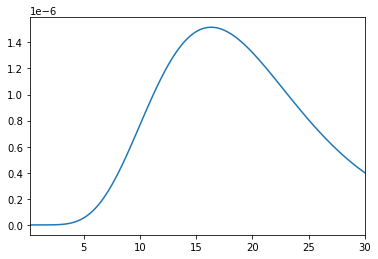

In [22]:
pd.Series(abs(P_cir - P).mean(1).mean(1), tau).plot()